KeyError: 'line_total'

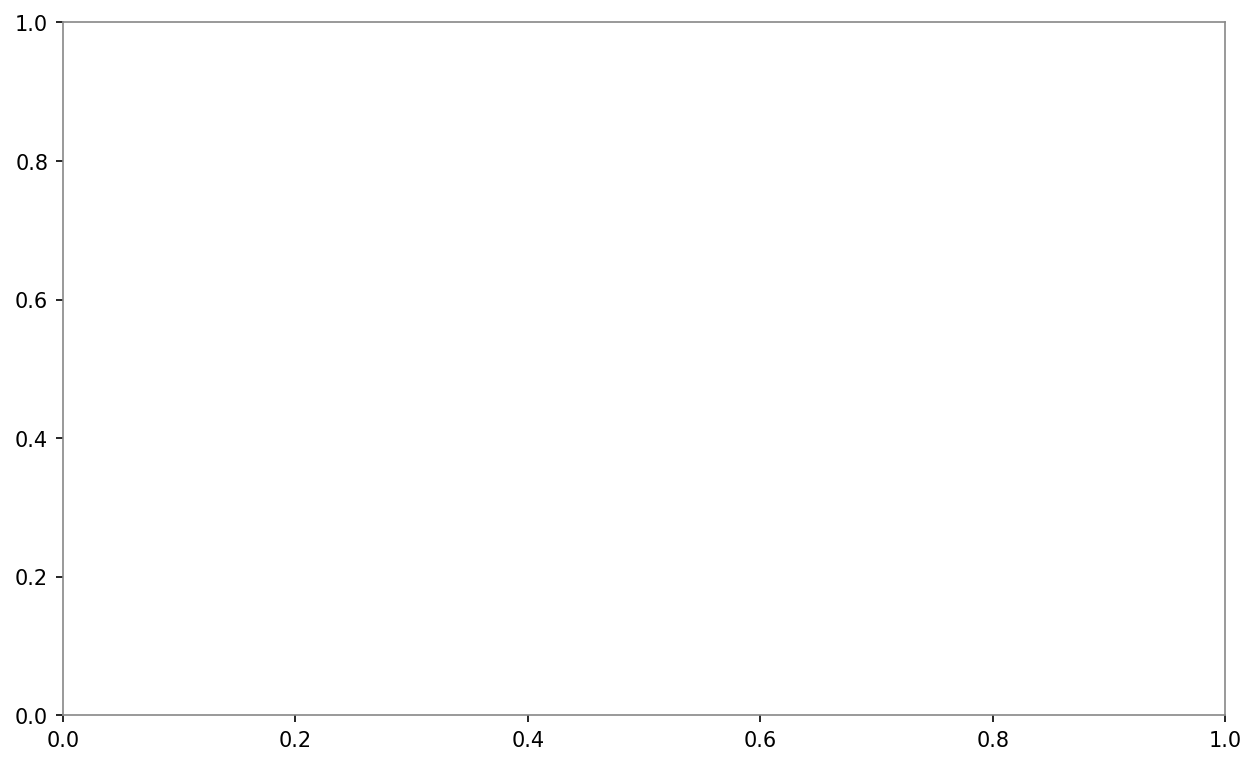

In [290]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if DB_URL is None:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

PALETTE = {
    "points":    "#8fa99a",  
    "points_ec": "#333333",  
    "line":      "#5f4d3e",  
    "highlight": "#8c6a5d",  
    "text":      "#966d5c",
    "grid":      "#e6e6e6",
}

plt.rcParams.update({
    "axes.facecolor":  "white",
    "figure.facecolor":"white",
    "axes.edgecolor":  "#888888",
    "grid.color":      PALETTE["grid"],
})


# בלבד (Raw Tables) לצורך שליפת טבלאות SQL- שימוש בשאילתות
# Using SQL queries to retrieve Raw Tables
df_track = pd.read_sql("select track_key, track_name, duration_seconds from dwh2.dim_track;", engine)
df_line  = pd.read_sql("select track_key, line_total  from dwh2.fact_invoiceline;", engine)

sales_per_track = df_line.groupby("track_key")["line_total"].sum()
df_track_line = df_track.merge(sales_per_track, on= "track_key", how= "inner").dropna(subset=["duration_seconds", "line_total"]).set_index("track_key")

pearson = df_track_line["duration_seconds"].corr(df_track_line["line_total"])
fit = np.polyfit(df_track_line["duration_seconds"].to_numpy(), df_track_line["line_total"].to_numpy(),1)
line = np.poly1d(fit)

# TOP 5 Resseler tracks:
# top_songs = df_track_line.nlargest(5, "line_total")


fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

ax.scatter(
    df_track_line["duration_seconds"], df["line_total"],
    s=35, alpha=0.7,
    color=PALETTE["points"],
    edgecolor=PALETTE["points_ec"], linewidth=0.6,
    label="Tracks" , zorder=1
)


x_line = np.linspace( df_track_line["duration_seconds"].min(),  df_track_line["duration_seconds"].max(), 300)
ax.plot(x_line, line(x_line), color=PALETTE["line"], linewidth=1.5, zorder=1, label="Regression")


top_sales = df_track_line(5, "line_total")
top_len = df_track_line.nlargest(5, "duration_seconds")


ax.scatter(edgecolor="#5a4036", linewidth=0.6, label="Top sales | Top length", s=40 , color=PALETTE["highlight"], zorder=3,
)

offsets = [(8,8), (8,-8), (-8,8), (-8,-8), (12,0)]
for i, (_, r) in enumerate(hi.iterrows()):
    ax.annotate(
        r["track_name"][:20],
        (r["duration_seconds"], r["linetotal_usd"]),
        textcoords="offset points", xytext=offsets[i % len(offsets)],
        fontsize=8, color=PALETTE["text"],
        bbox=dict(boxstyle="round,pad=0.22", facecolor="white", alpha=0.85, linewidth=0),
        arrowprops=dict(arrowstyle="-", color=PALETTE["highlight"], lw=0.6, alpha=0.9)
    )

ax.set_title("Track Length vs. Total (USD)", color=PALETTE["text"])
ax.set_xlabel("Length (seconds)", color=PALETTE["text"])
ax.set_ylabel("Total (USD)", color=PALETTE["text"])
ax.grid(axis="both", linestyle="--", alpha=0.5)

ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v):,}"))

ax.text(
    0.02, 0.812,
    f"Pearson r = {pearson:.3f}\nRegression: y = {fit[0]:.4f}x + {fit[1]:.2f}",
    transform=ax.transAxes, ha="left", va="top",
    color=PALETTE["text"],
    bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, linewidth=0.5)
)

ax.legend(frameon=False, loc="upper left")

plt.tight_layout()



# # הוספת נקודות מיוחדות בצבע שונה
# ax.scatter(top_songs["duration_sec"], top_songs["total_usd"],
#            color="darkred", s=80, label="Top Tracks", edgecolor="black")
# # PLOT #
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.scatter(df_track_line["duration_seconds"], df_track_line["line_total"], s=60, alpha= 0.4, label= "Tracks")
# ax.scatter(top_songs["duration_seconds"],top_songs["line_total"],
#            color= "grey", s= 100, label= "Top Tracks", edgecolor= "green", alpha = 0.8)
# x_line = np.linspace(df_track_line["duration_seconds"].min(), df_track_line["duration_seconds"].max(), 300)
# ax.plot(x_line, line(x_line), linewidth= 0.9 , label= "Regression")

# # for _, row in top_songs.iterrows():
# #     ax.text(row["duration_seconds"], row["line_total"],
# #             row["track_name"], fontsize= 8, ha="left", va="bottom")

# for _, r in top_songs.iterrows():
#     ax.annotate(
#         r["track_name"],
#         xy=(r["duration_seconds"], r["line_total"]),      # מיקום הנקודה
#         xytext=(28,-15),                               # הסטה קלה מהנקודה (בפיקסלים)
#         textcoords="offset points",
#         fontsize=7, ha="left", va="bottom",
#         bbox=dict(boxstyle="round,pad=0.2", fc="grey", alpha=0.1, lw=0.5),
#         arrowprops=dict(arrowstyle="-", lw=0.5, alpha=1)  # קו דק מהנקודה לטקסט
#     )

# ax.set_title("Track Length vs. Sales (USD)")
# ax.set_xlabel("Duration (seconds)")
# ax.set_ylabel("Total USD")
# ax.legend()
# ax.grid(True, linestyle="-",linewidth=0.11, color = "grey", alpha= 1)

# # annotate Pearson r & equation
# ax.text(0.025, 0.97, f" Pearson r = {pearson:.3f}\n Regression:  y = {fit[0]:.4f}x + {fit[1]:.2f} ",
#         transform=ax.transAxes, ha="left", va="top",
#         bbox=dict(boxstyle="round,pad=0.5", facecolor= "grey", alpha=0.1, linewidth=0.5))

# plt.tight_layout()

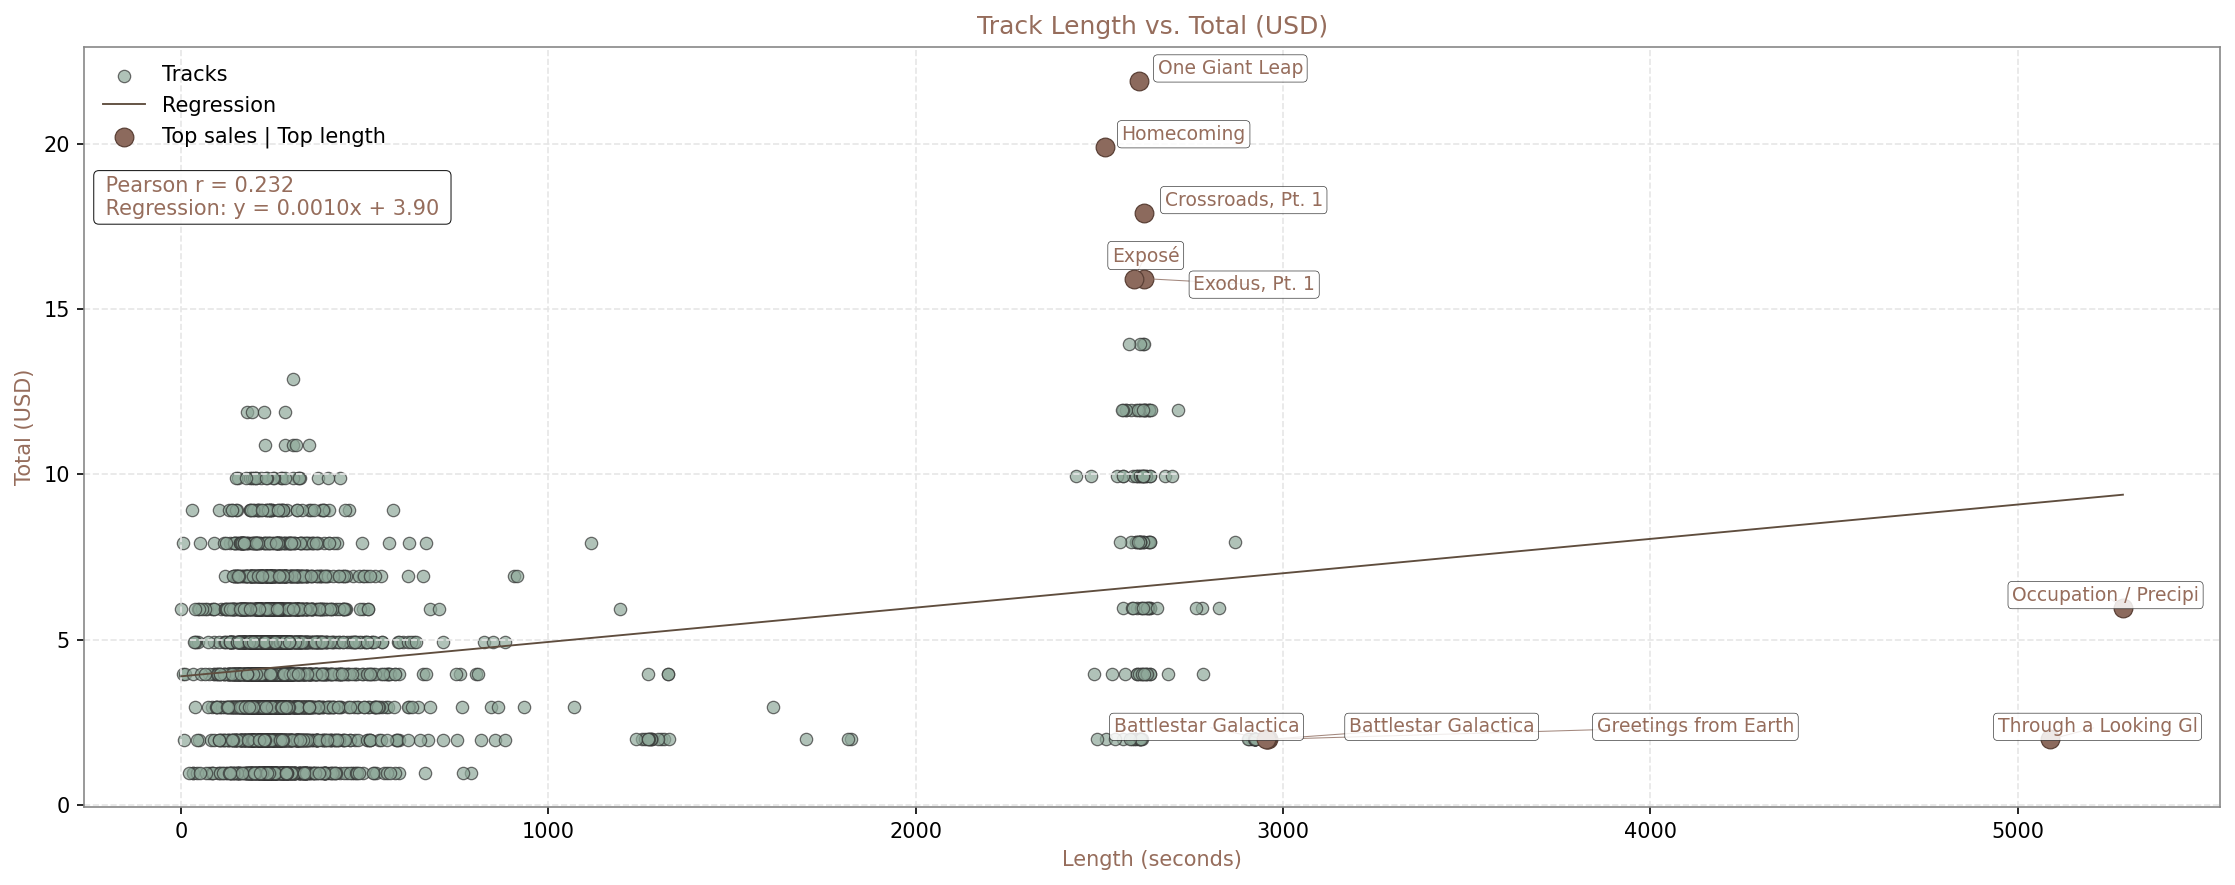

In [341]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sqlalchemy import create_engine
from dotenv import load_dotenv
from adjustText import adjust_text

# --- ENV & DB ---
load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

# --- Palette (הבהירה שביקשת) ---
PALETTE = {
    "points":    "#8fa99a",   # נקודות
    "points_ec": "#333333",   # מסגרת לנקודות
    "line":      "#5f4d3e",   # קו הרגרסיה
    "highlight": "#8c6a5d",   # נק' מודגשות
    "text":      "#966d5c",   # טקסטים/כותרות
    "grid":      "#e6e6e6",   # גריד
}

plt.rcParams.update({
    "axes.facecolor":  "white",
    "figure.facecolor":"white",
    "axes.edgecolor":  "#888888",
    "grid.color":      PALETTE["grid"],
})

# --- שליפת טבלאות גולמיות ---
df_track = pd.read_sql(
    "SELECT track_key, track_name, duration_seconds FROM dwh2.dim_track;", engine
)
df_line = pd.read_sql(
    "SELECT track_key, line_total FROM dwh2.fact_invoiceline;", engine
)

# --- סכימת מכירות לפי שיר + איחוד ---
sales_per_track = (df_line
                   .groupby("track_key", as_index=False)["line_total"]
                   .sum())

df_track_line = (df_track
                 .merge(sales_per_track, on="track_key", how="inner")
                 .dropna(subset=["duration_seconds", "line_total"])
                 .set_index("track_key"))

# --- קורלציה ורגרסיה ---
pearson = df_track_line["duration_seconds"].corr(df_track_line["line_total"])
fit = np.polyfit(df_track_line["duration_seconds"].to_numpy(),
                 df_track_line["line_total"].to_numpy(), 1)
line = np.poly1d(fit)

# --- Figure (מבנה/עמדה כמו בגרף הראשון) ---
fig, ax = plt.subplots(figsize=(15, 6), dpi=150)

# נקודות כלליות
ax.scatter(
    df_track_line["duration_seconds"], df_track_line["line_total"],
    s=35, alpha=0.7,
    color=PALETTE["points"],
    edgecolor=PALETTE["points_ec"], linewidth=0.6,
    label="Tracks", zorder=1
)

# קו רגרסיה
x_line = np.linspace(df_track_line["duration_seconds"].min(),
                     df_track_line["duration_seconds"].max(), 300)
ax.plot(x_line, line(x_line),
        color=PALETTE["line"], linewidth=0.9,
        zorder=2, label="Regression")

# --- הדגשת TOP: לפי מכירות ולפי אורך ---
top_sales = df_track_line.nlargest(5, "line_total")
top_len   = df_track_line.nlargest(5, "duration_seconds")
hi = (pd.concat([top_sales, top_len])
        .reset_index()
        .drop_duplicates(subset="track_key"))

# נקודות מודגשות
ax.scatter(
    hi["duration_seconds"], hi["line_total"],
    s=80 , color=PALETTE["highlight"], zorder=3,
    edgecolor="#5a4036", linewidth= 0.6,
    label="Top sales | Top length"
)

# --- תוויות: יצירת טקסטים ואז פיזור אוטומטי (adjustText) ---
texts = []
for _, r in hi.iterrows():
    t = ax.text(
        r["duration_seconds"], r["line_total"],
        r["track_name"][:20],  # קיצור עדין לשמות ארוכים
        fontsize=9, color=PALETTE["text"],
        bbox=dict(boxstyle="round,pad=0.22", facecolor="white", alpha=0.85, linewidth=0.3),
        zorder=4
    )
    texts.append(t)

# פיזור תוויות כדי למנוע חפיפות; שרטוט חצים דקיקים לנקודות
adjust_text(
    texts, ax=ax,
    expand_points=(1.2, 1.4),     # ריחוק מינימלי מהנקודות
    expand_text=(1.05, 1.2),      # ריחוק בין טקסטים
    force_text=0.5, force_points=0.3,
    arrowprops=dict(arrowstyle="-", lw=0.5, color=PALETTE["highlight"], alpha=0.8)
)

# --- עיצוב סופי (כמו בגרף הראשון) ---
ax.set_title("Track Length vs. Total (USD)", color=PALETTE["text"])
ax.set_xlabel("Length (seconds)", color=PALETTE["text"])
ax.set_ylabel("Total (USD)", color=PALETTE["text"])
ax.grid(axis="both", linestyle="--", alpha=1)

ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v):,}"))

ax.text(
    0.0068, 0.83,
    f" Pearson r = {pearson:.3f}\n Regression: y = {fit[0]:.4f}x + {fit[1]:.2f} ",
    transform=ax.transAxes, ha="left", va="top",
    color=PALETTE["text"],
    bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, linewidth=0.5)
)

ax.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.show()


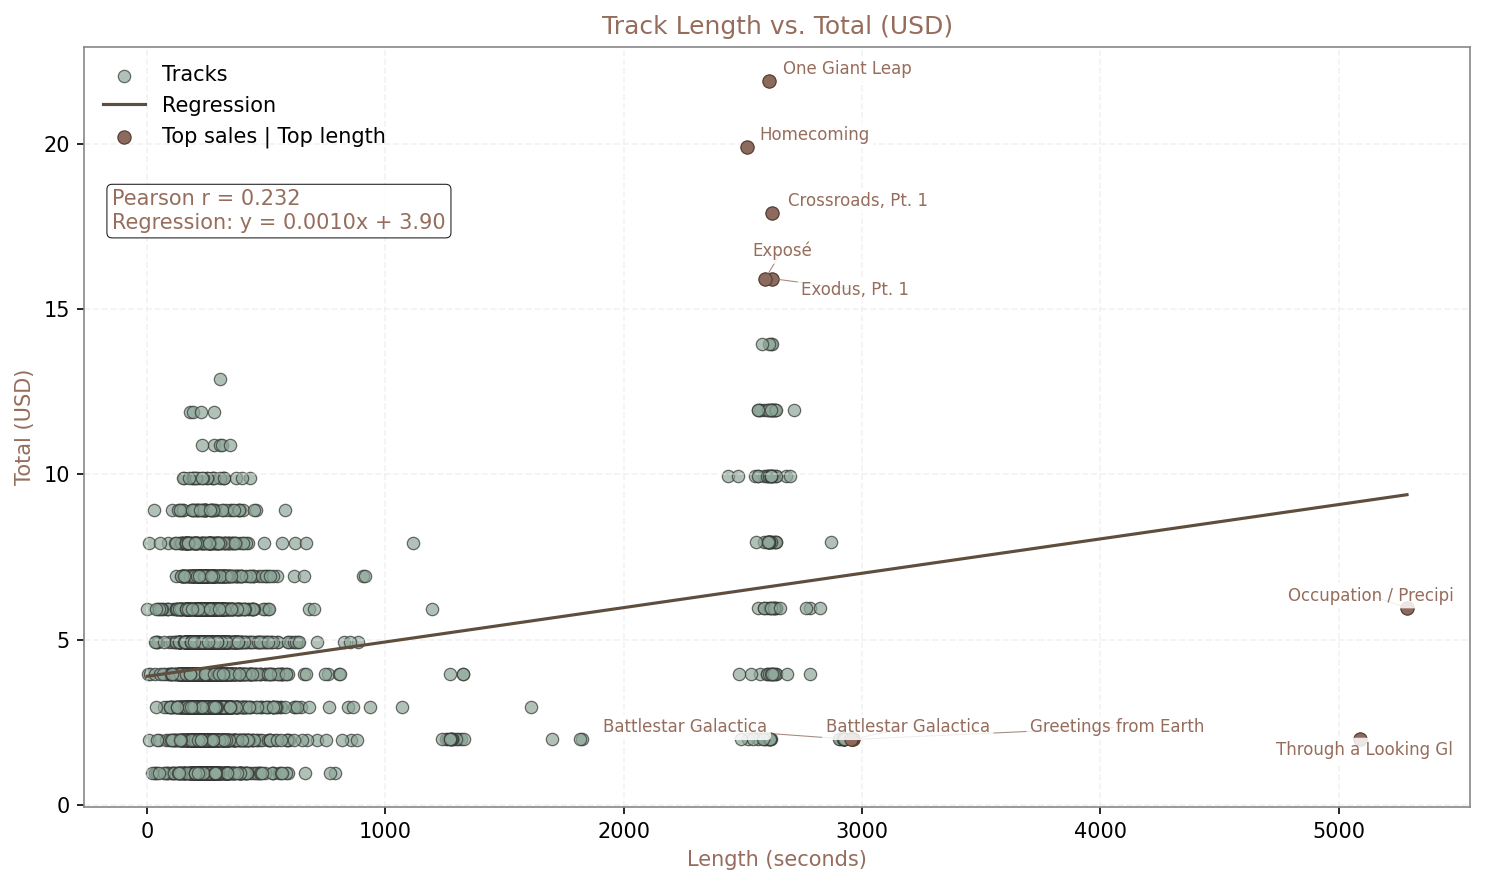

In [345]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sqlalchemy import create_engine
from dotenv import load_dotenv
from adjustText import adjust_text

# ENV & DB: 
load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

# PALETTE: 
PALETTE = {
    "points":    "#8fa99a",   
    "points_ec": "#333333",   
    "line":      "#5f4d3e",  
    "highlight": "#8c6a5d",  
    "text":      "#966d5c",  
    "grid":      "#e6e6e6",  
}

plt.rcParams.update({
    "axes.facecolor":  "white",
    "figure.facecolor":"white",
    "axes.edgecolor":  "#888888",
    "grid.color":      PALETTE["grid"],
})

# SQL queries to retrieve Raw Tables:
df_track = pd.read_sql("select track_key, track_name, duration_seconds from dwh2.dim_track;", engine)
df_line = pd.read_sql("select track_key, line_total from dwh2.fact_invoiceline;", engine)


sales_per_track = (df_line .groupby("track_key", as_index=False)["line_total"].sum())
df_track_line = (df_track.merge(sales_per_track, on="track_key", how="inner").dropna(subset=["duration_seconds", "line_total"]).set_index("track_key"))


pearson = df_track_line["duration_seconds"].corr(df_track_line["line_total"])
fit = np.polyfit(df_track_line["duration_seconds"].to_numpy(),df_track_line["line_total"].to_numpy(), 1)
line = np.poly1d(fit)

# FIGURE:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# general details:
ax.scatter(
    df_track_line["duration_seconds"], df_track_line["line_total"],
    s=35, alpha=0.7,
    color=PALETTE["points"],
    edgecolor=PALETTE["points_ec"], linewidth=0.6,
    label="Tracks", zorder=1
)

# regression line:
x_line = np.linspace(df_track_line["duration_seconds"].min(),
                     df_track_line["duration_seconds"].max(), 300)
ax.plot(x_line, line(x_line),
        color=PALETTE["line"], linewidth=1.5,
        zorder=2, label="Regression")

# tops:
top_sales = df_track_line.nlargest(5, "line_total")
top_len   = df_track_line.nlargest(5, "duration_seconds")
hi = (pd.concat([top_sales, top_len])
        .reset_index()
        .drop_duplicates(subset="track_key"))

ax.scatter(
    hi["duration_seconds"], hi["line_total"],
    s=40, color=PALETTE["highlight"], zorder=3,
    edgecolor="#5a4036", linewidth=0.6,
    label="Top sales | Top length"
)


texts = []
for _, r in hi.iterrows():
    t = ax.text(
        r["duration_seconds"], r["line_total"],
        r["track_name"][:20],
        fontsize=8, color=PALETTE["text"],
        bbox=dict(boxstyle="round,pad=0.22", facecolor="white", alpha=0.85, linewidth=0),
        zorder=4
    )
    texts.append(t)

adjust_text(
    texts, ax=ax,
    expand_points=(1.2, 1.4),
    expand_text=(1.05, 1.2),
    force_text=0.5, force_points=0.3,
    arrowprops=dict(arrowstyle="-", lw=0.5, color=PALETTE["highlight"], alpha=0.8)
)

# final design:
ax.set_title("Track Length vs. Total (USD)", color=PALETTE["text"])
ax.set_xlabel("Length (seconds)", color=PALETTE["text"])
ax.set_ylabel("Total (USD)", color=PALETTE["text"])
ax.grid(axis="both", linestyle="--", alpha=0.5)

ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v):,}"))

ax.text(
    0.02, 0.812,
    f"Pearson r = {pearson:.3f}\nRegression: y = {fit[0]:.4f}x + {fit[1]:.2f}",
    transform=ax.transAxes, ha="left", va="top",
    color=PALETTE["text"],
    bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, linewidth=0.5)
)

ax.legend(frameon=False, loc="upper left")
plt.tight_layout()


plt.savefig("Length_vs_Sales_correlation.png", dpi=220, bbox_inches="tight")
plt.show()

Enter DB password:  ········


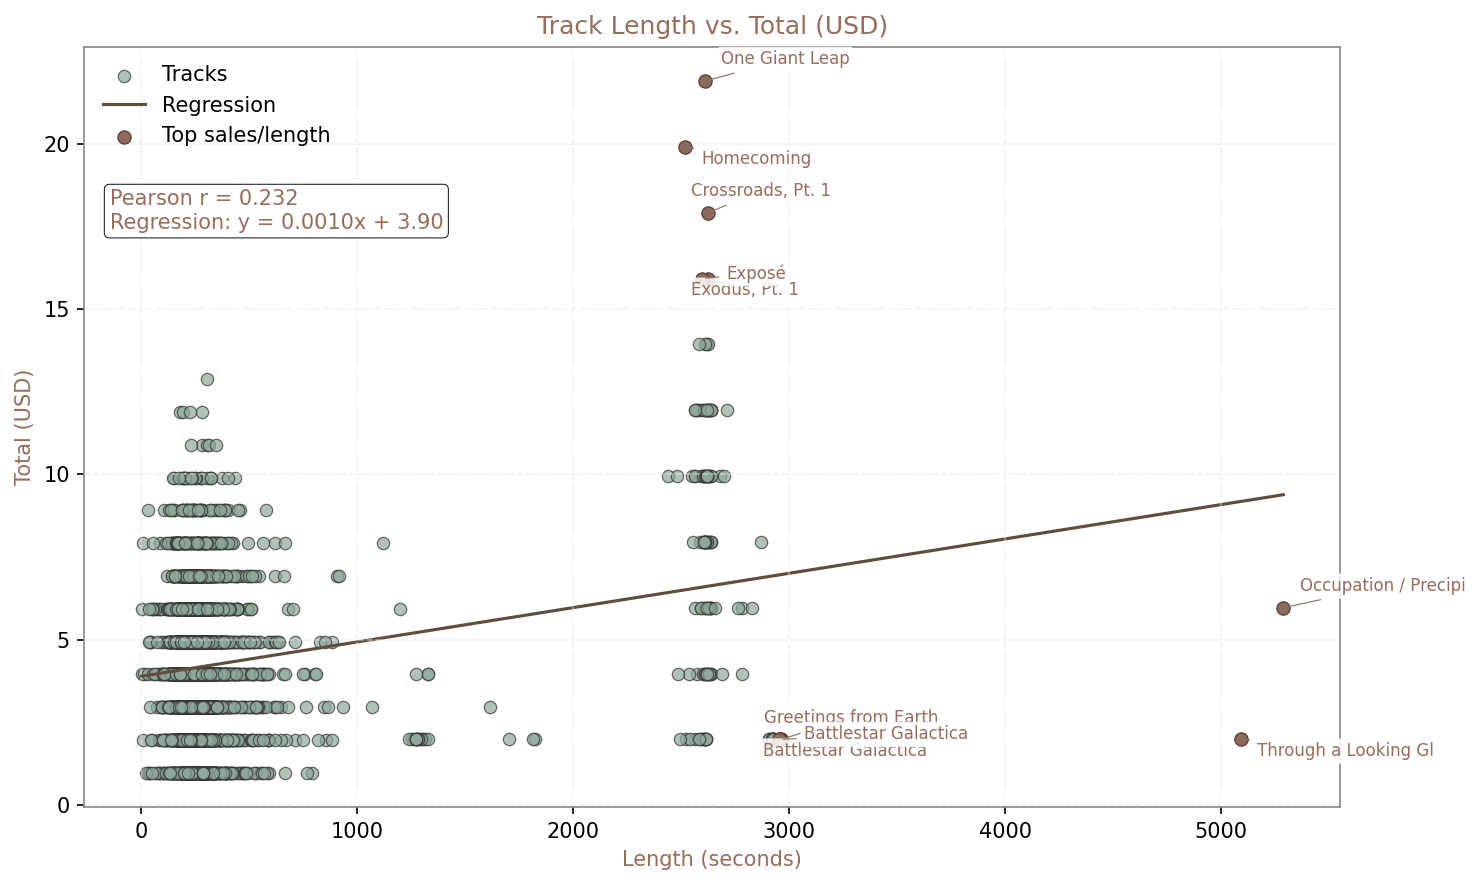

In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sqlalchemy import create_engine
from getpass import getpass

user = "postgres"
password = getpass("Enter DB password: ")
host = "localhost"
port = "5432"
database = "chinook"

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")


PALETTE = {
    "points":    "#8fa99a",  
    "points_ec": "#333333",  
    "line":      "#5f4d3e",  
    "highlight": "#8c6a5d",  
    "text":      "#966d5c",
    "grid":      "#e6e6e6",
}

plt.rcParams.update({
    "axes.facecolor":  "white",
    "figure.facecolor":"white",
    "axes.edgecolor":  "#888888",
    "grid.color":      PALETTE["grid"],
})

sql = """
with line_sales as (
  select il.track_key as track_id,
         sum(il.unitprice * il.quantity) as total_usd
  from dwh2.fact_invoiceline il
  group by il.track_key
),
track_len as (
  select t.track_key as track_id,
         t.track_name,
         (t.milliseconds/1000.0) as duration_sec
  from dwh2.dim_track t
),
joined as (
  select tl.track_name,
         tl.duration_sec,
         ls.total_usd
  from track_len tl
  join line_sales ls on tl.track_id = ls.track_id
  where tl.duration_sec is not null
)
select *
from joined
;
"""

df = pd.read_sql(sql, engine)


pearson = df["duration_sec"].corr(df["total_usd"])
fit = np.polyfit(df["duration_sec"], df["total_usd"], 1)
line = np.poly1d(fit)


fig, ax = plt.subplots(figsize=(10, 6), dpi=150)


ax.scatter(
    df["duration_sec"], df["total_usd"],
    s=35, alpha=0.7,
    color=PALETTE["points"],
    edgecolor=PALETTE["points_ec"], linewidth=0.6,
    label="Tracks" , zorder=1
)


x_line = np.linspace(df["duration_sec"].min(), df["duration_sec"].max(), 300)
ax.plot(x_line, line(x_line), color=PALETTE["line"], linewidth=1.5, zorder=1, label="Regression")


top_sales = df.nlargest(5, "total_usd")
top_len   = df.nlargest(5, "duration_sec")
hi = pd.concat([top_sales, top_len]).drop_duplicates()

ax.scatter(
    hi["duration_sec"], hi["total_usd"],
    s=40 , color=PALETTE["highlight"], zorder=3,
    edgecolor="#5a4036", linewidth=0.6,
    label="Top sales/length"
)

offsets = [(8,8), (8,-8), (-8,8), (-8,-8), (12,0)]
for i, (_, r) in enumerate(hi.iterrows()):
    ax.annotate(
        r["track_name"][:20],
        (r["duration_sec"], r["total_usd"]),
        textcoords="offset points", xytext=offsets[i % len(offsets)],
        fontsize=8, color=PALETTE["text"],
        bbox=dict(boxstyle="round,pad=0.22", facecolor="white", alpha=0.85, linewidth=0),
        arrowprops=dict(arrowstyle="-", color=PALETTE["highlight"], lw=0.6, alpha=0.9)
    )

ax.set_title("Track Length vs. Total (USD)", color=PALETTE["text"])
ax.set_xlabel("Length (seconds)", color=PALETTE["text"])
ax.set_ylabel("Total (USD)", color=PALETTE["text"])
ax.grid(axis="both", linestyle="--", alpha=0.5)

ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v):,}"))

ax.text(
    0.02, 0.812,
    f"Pearson r = {pearson:.3f}\nRegression: y = {fit[0]:.4f}x + {fit[1]:.2f}",
    transform=ax.transAxes, ha="left", va="top",
    color=PALETTE["text"],
    bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, linewidth=0.5)
)

ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.savefig("length_vs_sales_correlation_using_SQL.png", dpi=220)
plt.show()

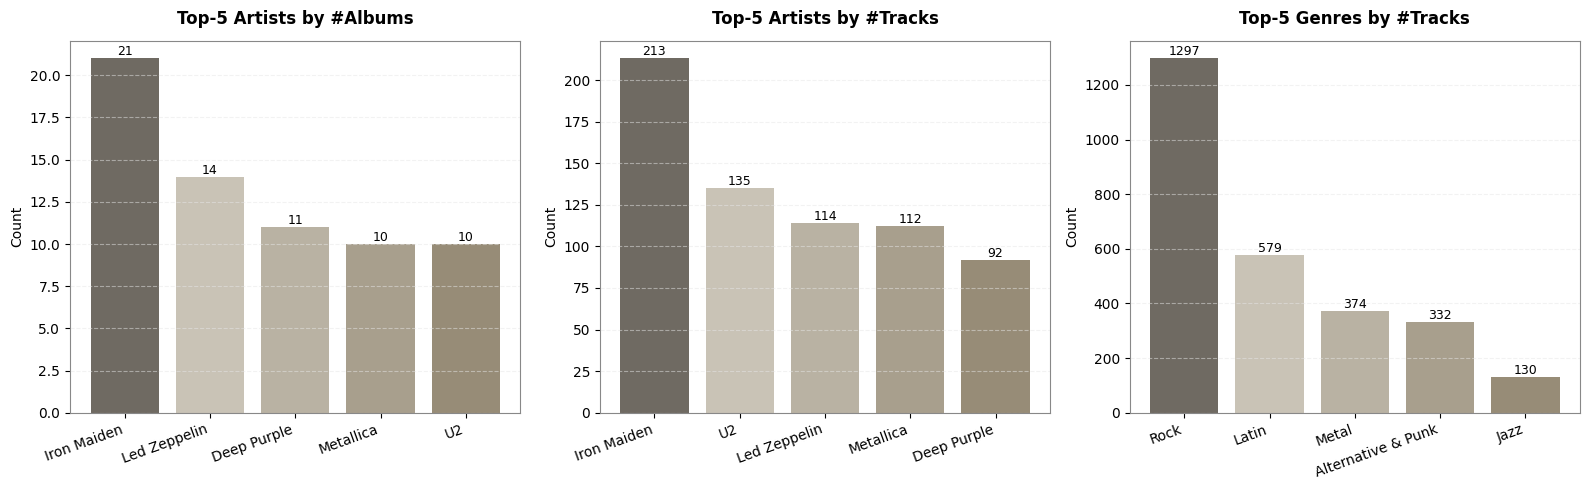

In [364]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)


HIGHLIGHT_THRESHOLD = 0.25
PALETTE = {
    "base":   ["#d8d2c4", "#c9c3b6", "#b9b2a3", "#a89f8d", "#978c77"],  # פסטלים חום עתיק
    "accent": "#6f6a62",                                               # הדגשה כהה
}
plt.rcParams.update({
    "axes.facecolor":  "white",
    "figure.facecolor":"white",
    "axes.edgecolor":  "#888888",
    "grid.color":      "#e6e6e6",
    "axes.titleweight":"bold",
    "axes.titlepad":   12,
})


df = pd.read_sql("select artist_name, album_title, genre from dwh2.dim_track", engine)


# Top 5 artists_albums:
df_albums = (
    df.dropna(subset=["artist_name", "album_title"])
      .groupby("artist_name")["album_title"].nunique()
      .reset_index(name="albums_cnt")
      .sort_values(["albums_cnt", "artist_name"], ascending=[False, True])
      .head(5)
)

# Top 5 artists_tracks:
df_tracks = (
    df.dropna(subset=["artist_name"])
      .groupby("artist_name")
      .size()
      .reset_index(name="tracks_cnt")
      .sort_values(["tracks_cnt", "artist_name"], ascending=[False, True])
      .head(5)
)

# TOP 5 genres_tracks:
df_genres = (
    df.dropna(subset=["genre"])
      .groupby("genre")
      .size()
      .reset_index(name="tracks_cnt")
      .rename(columns={"genre": "genre_name"})
      .sort_values(["tracks_cnt", "genre_name"], ascending=[False, True])
      .head(5)
)

# check:
# print("        Top 5 artists_tracks: \n", df_albums,"\n ", "\n        Top 5 artists_tracks: \n", df_tracks, "\n ", "\n               Top 5 genres_tracks: \n", df_genres)



def bar_with_highlights(ax, categories, values, title):
    cats = list(categories)
    vals = pd.Series(values, dtype="float64")

    avg = vals.mean()
    base = PALETTE["base"]
    colors = [
        PALETTE["accent"] if v >= avg * (1 + HIGHLIGHT_THRESHOLD)
        else base[i % len(base)]
        for i, v in enumerate(vals)
    ]

    bars = ax.bar(range(len(cats)), vals, color=colors)
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_ylabel("Count")

    ax.set_xticks(range(len(cats)))
    ax.set_xticklabels(cats, rotation=20, ha="right")

    for b in bars:
        ax.text(b.get_x() + b.get_width()/2,
                b.get_height(),
                f"{int(b.get_height())}",
                ha="center", va="bottom", fontsize=9)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

bar_with_highlights(
    axes[0],
    df_albums["artist_name"],
    df_albums["albums_cnt"],
    "Top-5 Artists by #Albums"
)
bar_with_highlights(
    axes[1],
    df_tracks["artist_name"],
    df_tracks["tracks_cnt"],
    "Top-5 Artists by #Tracks"
)
bar_with_highlights(
    axes[2],
    df_genres["genre_name"],
    df_genres["tracks_cnt"],
    "Top-5 Genres by #Tracks"
)

plt.tight_layout()
plt.savefig("top5_artists_albums_tracks_genres.png", dpi=180)
plt.show()


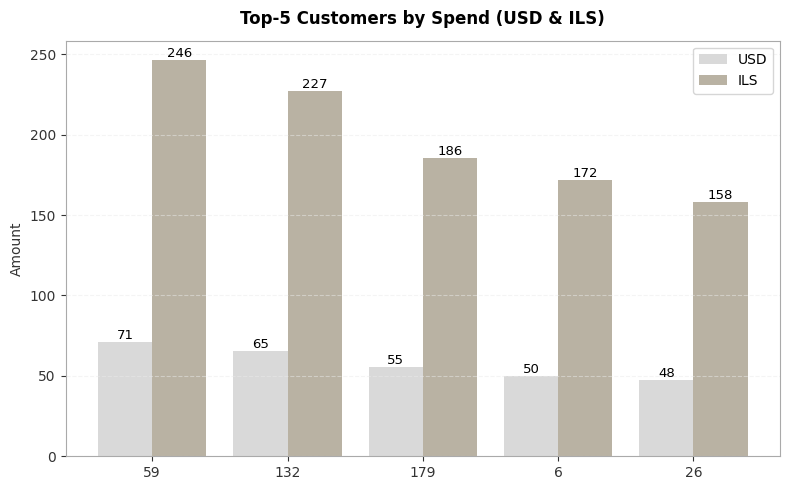

In [370]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

HIGHLIGHT_THRESHOLD = 0.25
PALETTE = {
    "usd":     "#d9d9d9",
    "ils":     "#b9b2a3",
    "accent":  "#8c6b4f",
    "grid":    "#eaeaea"
}
plt.rcParams.update({
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.edgecolor": "#aaaaaa",
    "grid.color": PALETTE["grid"],
    "axes.labelcolor": "#333333",
    "xtick.color": "#333333",
    "ytick.color": "#333333",
    "font.size": 10
})


df_inv = pd.read_sql("select invoice_key as invoice_id, customer_key as customer_id, cast(invoice_date as date) as invoice_date from dwh2.fact_invoice", engine)
df_line = pd.read_sql("select invoice_key as invoice_id, line_total as inv_total_usd from dwh2.fact_invoiceline", engine) 
df_cur = pd.read_sql("select cast(rate_date as date) as rate_date, usd_ils_rate from dwh2.dim_currency", engine)



sum_per_inv = (df_line.groupby("invoice_id", as_index=False)["inv_total_usd"].sum())
inv_with_sum = df_inv.merge(sum_per_inv, on="invoice_id", how="inner")

# check:
# print("inv_with_sum: \n", inv_with_sum," \n ","sum_per_inv:  \n:", sum_per_inv)

inv_with_rate = (
    inv_with_sum.merge(df_cur, left_on="invoice_date", right_on="rate_date", how="left")
                .assign(usd_ils_rate=lambda d: d["usd_ils_rate"].fillna(3.5),
                    inv_total_ils = lambda d: d["inv_total_usd"] * d["usd_ils_rate"])
)
df = (
    inv_with_rate.groupby("customer_id", as_index=False)
                 .agg(total_usd=("inv_total_usd", "sum"), total_ils=("inv_total_ils", "sum"))
                 .sort_values("total_usd", ascending=False)
                 .head(5)
)
df["customer_id"] = df["customer_id"].astype(str)


fig, ax = plt.subplots(figsize=(8, 5))

x = range(len(df))
bars_usd = ax.bar([i - 0.2 for i in x], df["total_usd"], width=0.4,
                  label="USD", color=PALETTE["usd"])
bars_ils = ax.bar([i + 0.2 for i in x], df["total_ils"], width=0.4,
                  label="ILS", color=PALETTE["ils"])

ax.set_xticks(list(x))
ax.set_xticklabels(df["customer_id"], rotation=0)
ax.set_title("Top-5 Customers by Spend (USD & ILS)")
ax.set_ylabel("Amount")
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend()

def label_bars(bars):
    for b in bars:
        val = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, val, f"{val:,.0f}",
                ha="center", va="bottom", fontsize=9.5)

label_bars(bars_usd)
label_bars(bars_ils)

plt.tight_layout()
plt.savefig("top5_customers_spend_usd_ils.png", dpi=180)
plt.show()

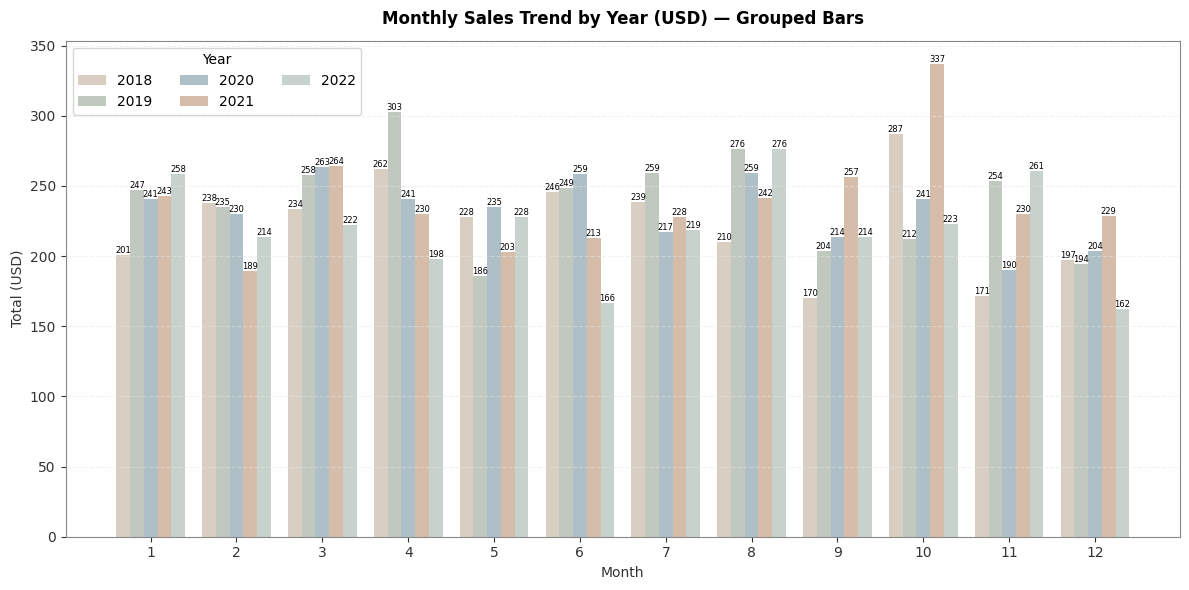

In [373]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

df_inv = pd.read_sql("select invoice_key as invoice_id, invoice_date as invoice_date from dwh2.fact_invoice", engine)
df_line = pd.read_sql("select invoice_key as invoice_id, line_total as line_total_usd from dwh2.fact_invoiceline", engine)


sum_per_inv = (df_line.groupby("invoice_id", as_index=False)["line_total_usd"].sum())
inv_with_sum = df_inv.merge(sum_per_inv, on= "invoice_id", how= "inner")
inv_with_sum["invoice_date"] = pd.to_datetime(inv_with_sum["invoice_date"])
inv_with_sum["year_"]  = inv_with_sum["invoice_date"].dt.year.astype(int)
inv_with_sum["month_"] = inv_with_sum["invoice_date"].dt.month.astype(int)

df = (inv_with_sum.groupby(["year_", "month_"], as_index=False)["line_total_usd"].sum().rename(columns={"line_total_usd": "total_usd"}))
pvt = (df.pivot(index="month_", columns="year_", values="total_usd").fillna(0).sort_index())
months  = pvt.index.tolist()
years   = pvt.columns.tolist()
n_years = len(years)


PALETTE = ["#d8cfc2", "#c0c8bf", "#aebfc7", "#d6bda9", "#c7d2cc", "#bfc7d9"]
colors  = [PALETTE[i % len(PALETTE)] for i in range(n_years)]

plt.rcParams.update({
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.edgecolor": "#888888",
    "grid.color": "#e6e6e6",
})

fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(months))
bar_width = 0.8 / max(n_years, 1)

bars_per_year = []
for idx, yr in enumerate(years):
    offsets = [i - 0.4 + bar_width/2 + idx * bar_width for i in x]
    bars = ax.bar(offsets, pvt[yr].values,
                  width=bar_width, label=str(yr), color=colors[idx])
    bars_per_year.append(bars)

ax.set_title("Monthly Sales Trend by Year (USD) — Grouped Bars", pad=12, fontsize=12)
ax.set_xlabel("Month")
ax.set_ylabel("Total (USD)")
ax.set_xticks(list(x))
ax.set_xticklabels(months)
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend(title="Year", ncol=min(3, n_years), frameon=True)

for bars in bars_per_year:
    for b in bars:
        v = b.get_height()
        if v > 0:
            ax.text(b.get_x() + b.get_width()/2, v, f"{v:,.0f}",
                    ha="center", va="bottom", fontsize=6)

plt.tight_layout()
# plt.savefig("monthly_sales_trend_bars.png", dpi=180)
plt.show()


In [375]:
# engine = create_engine(DB_URL)

# sql_top_genres = """
# with cust_track as (
#  select fi.customer_key,
#  		il.track_key 
#  from dwh2.fact_invoiceline il
#   join dwh2.fact_invoice fi on il.invoice_key = fi.invoice_key
# ),
# cust_genre as (
#  select c.customer_key,
# 		dt.genre,
# 		count(*) as cnt
#  from cust_track c
#  join dwh2.dim_track dt on c.track_key = dt.track_key 
#  where dt.genre IS NOT NULL
#  group by c.customer_key,
#  		  dt.genre
# ),
# ranked as (
#  select 
# 	customer_key, 
# 	genre, 
# 	cnt,
#     dense_rank() over(partition by customer_key order by cnt DESC, genre) as rnk
#  from cust_genre
# )
#  select
# 	customer_key as customer_id,
# 	genre as genre_name
#  from ranked
#  where rnk <= 2
#  order by customer_key,
#  		  rnk, 
# 		  genre
# ;
# """
# # שלב 2: כל השירים שהלקוח כבר רכש
# sql_purchased = """
# select
# 	fi.customer_key as customer_id, 
# 	il.track_key as track_id
# from dwh2.fact_invoiceline il
# join dwh2.fact_invoice fi on il.invoice_key = fi.invoice_key
# ;
# """
# # שלב 3: פופולריות כללית של שירים לפי ז'אנר 
# sql_popularity = """
# with pop as (
#  select dt.track_key,
#  		dt.genre, 
# 		count(*) as purchases
#  from dwh2.fact_invoiceline il
#  join dwh2.dim_track dt on il.track_key = dt.track_key
#  where dt.genre IS NOT NULL
#  group by dt.track_key, 
#  		  dt.genre
# )
#  select 
# 	tracK_key as track_id,
# 	genre as genre_name, 
# 	purchases
#  from pop
# ;
# """

# top_genres = pd.read_sql(sql_top_genres, engine)
# purchased = pd.read_sql(sql_purchased, engine)
# pop = pd.read_sql(sql_popularity, engine)

# purchased_set = (
#     purchased.groupby("customer_id")["track_id"]
#     .apply(set)
#     .to_dict()
# )

# pop_by_genre = (
#     pop.sort_values(["genre_name", "purchases"], ascending=[True, False])
#         .groupby("genre_name")["track_id"]
#         .apply(list)
#         .to_dict()
# )

# recs = []
# for cust, sub in top_genres.groupby("customer_id"):
#     owned = purchased_set.get(cust, set())
#     for genre in sub["genre_name"].tolist():
#         candidates = [t for t in pop_by_genre.get(genre, []) if t not in owned]
#         chosen = candidates[:3] 
#         recs.append({"customer_id ": cust, " genre_name ": genre, " recommended_track_ids": chosen})

# df_recs = pd.DataFrame(recs)

# df_recs.to_csv("recommendations_using_SQL.csv", index=False)
# print("PREVIEW:")
# print("\n", df_recs.head(10))
# print("\nSAVED: recommendations_using_SQL.csv")

PREVIEW:

    customer_id   genre_name   recommended_track_ids
0             1         Rock     [2672, 2153, 1401]
1             1        Latin       [380, 1523, 241]
2             2         Rock     [2672, 2153, 1401]
3             2        Blues       [2541, 915, 892]
4             3        Metal      [1226, 416, 1834]
5             3         Jazz       [635, 1192, 467]
6             4         Rock     [2672, 2153, 1401]
7             4    Classical     [3446, 3500, 3482]
8             5         Rock     [2672, 2153, 2968]
9             5        Metal      [1226, 416, 1834]

SAVED: recommendations_using_SQL.csv


In [385]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

df_il = pd.read_sql("select invoice_key as invoice_id, track_key from dwh2.fact_invoiceline", engine)
df_i = pd.read_sql("select invoice_key as invoice_id, customer_key as customer_id from dwh2.fact_invoice", engine)
df_t = pd.read_sql("select track_key, genre from dwh2.dim_track", engine)

cust_track = df_il.merge(df_i, on="invoice_id", how="inner")[["customer_id", "track_key"]]
cust_track = cust_track.merge(df_t, on="track_key", how="left")
cust_track = cust_track.dropna(subset=["genre"])

cust_genre = (cust_track
              .groupby(["customer_id", "genre"], as_index=False)
              .size()
              .rename(columns={"size": "cnt"}))

cust_genre = cust_genre.sort_values(["customer_id", "cnt", "genre"],
                                    ascending=[True, False, True])
cust_genre["rnk"] = (cust_genre
                     .groupby("customer_id")["cnt"]
                     .rank(method="dense", ascending=False))

top_genres = (cust_genre[cust_genre["rnk"] <= 2]
              .loc[:, ["customer_id", "genre"]]
              .rename(columns={"genre": "genre_name"})
              .sort_values(["customer_id", "genre_name"])
              .reset_index(drop=True))

purchased = cust_track[["customer_id", "track_key"]].drop_duplicates()
purchased_set = (purchased
                 .groupby("customer_id")["track_key"]
                 .apply(set)
                 .to_dict())

pop = (df_il.merge(df_t, on="track_key", how="left")
           .dropna(subset=["genre"]))
pop = (pop
       .groupby(["track_key", "genre"], as_index=False)
       .size()
       .rename(columns={"size": "purchases",
                        "track_key": "track_id",
                        "genre": "genre_name"}))

pop = pop.sort_values(["genre_name", "purchases"], ascending=[True, False])
pop_by_genre = (pop
                .groupby("genre_name")["track_id"]
                .apply(list)
                .to_dict())

recs = []
for cust, sub in top_genres.groupby("customer_id"):
    owned = purchased_set.get(cust, set())
    for genre in sub["genre_name"].tolist():
        candidates = [t for t in pop_by_genre.get(genre, []) if t not in owned]
        chosen = candidates[:3]
        recs.append({
            "customer_id": cust,
            "genre_name": genre,
            "recommended_track_ids": chosen
})

df_recs = pd.DataFrame(recs)

df_recs.to_csv("recommendations(_pandas).csv", index=False)
print("PREVIEW:")
print("\n", df_recs.head(10))
print("\nSAVED: recommendations.csv")


PREVIEW:

    customer_id genre_name recommended_track_ids
0            1      Latin       [380, 241, 594]
1            1       Rock    [2672, 1401, 2153]
2            2      Blues       [195, 892, 900]
3            2       Rock    [2672, 1401, 2153]
4            3       Jazz       [635, 124, 467]
5            3      Metal     [1226, 416, 1353]
6            4  Classical    [3446, 3482, 3488]
7            4      Latin       [380, 241, 594]
8            4       Rock    [2672, 1401, 2153]
9            5      Metal     [1226, 416, 1353]

SAVED: recommendations.csv


In [ ]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

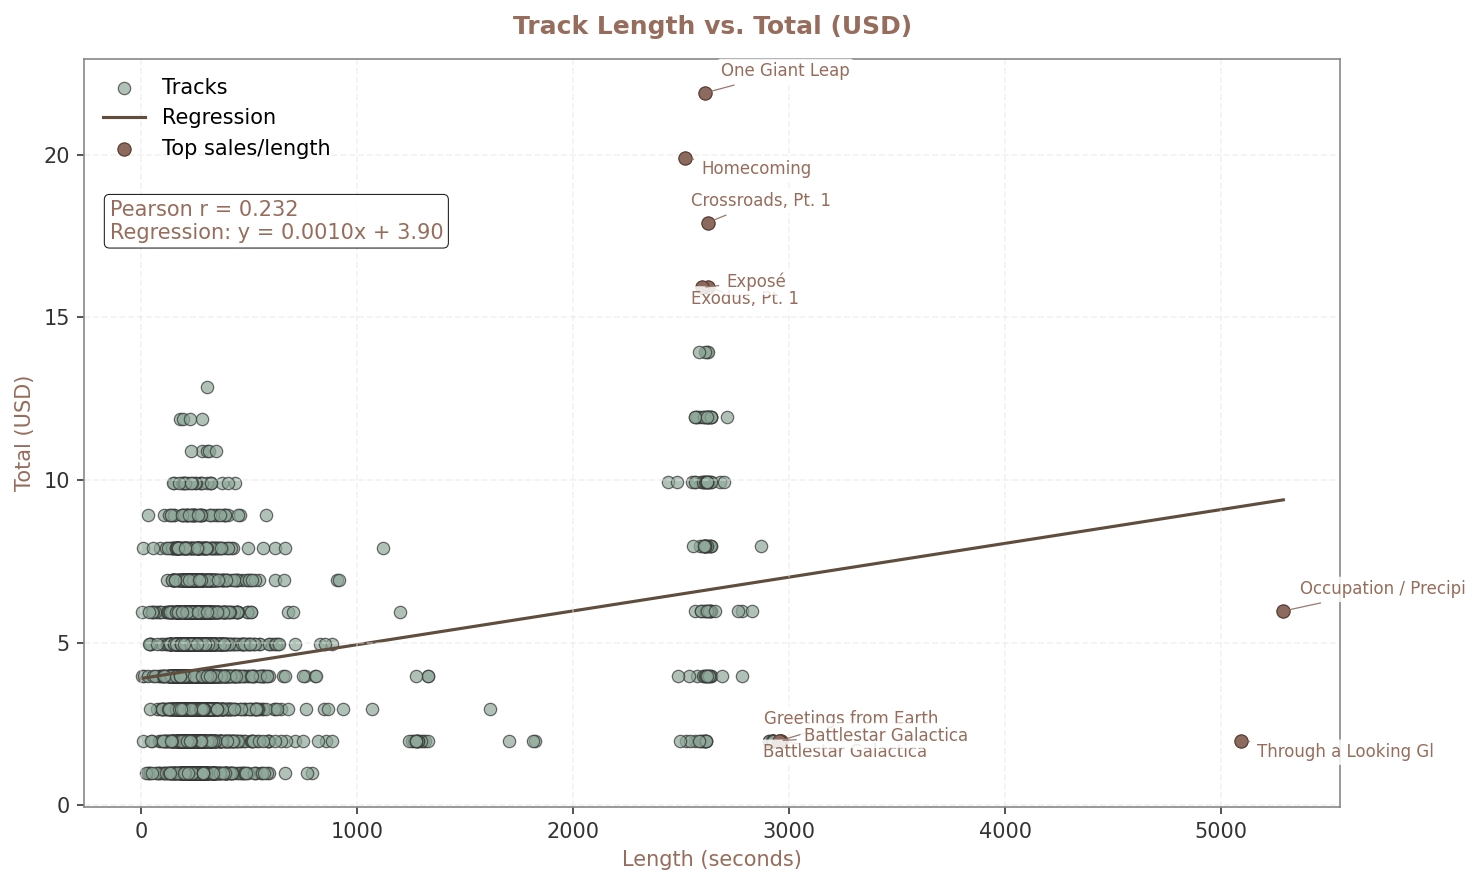

In [388]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sqlalchemy import create_engine
from getpass import getpass
import os
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

PALETTE = {
    "points":    "#8fa99a",  
    "points_ec": "#333333",  
    "line":      "#5f4d3e",  
    "highlight": "#8c6a5d",  
    "text":      "#966d5c",
    "grid":      "#e6e6e6",
}

plt.rcParams.update({
    "axes.facecolor":  "white",
    "figure.facecolor":"white",
    "axes.edgecolor":  "#888888",
    "grid.color":      PALETTE["grid"],
})

sql = """
with line_sales as (
  select il.track_key as track_id,
         sum(il.unitprice * il.quantity) as total_usd
  from dwh2.fact_invoiceline il
  group by il.track_key
),
track_len as (
  select t.track_key as track_id,
         t.track_name,
         (t.milliseconds/1000.0) as duration_sec
  from dwh2.dim_track t
),
joined as (
  select tl.track_name,
         tl.duration_sec,
         ls.total_usd
  from track_len tl
  join line_sales ls on tl.track_id = ls.track_id
  where tl.duration_sec is not null
)
select *
from joined
;
"""

df = pd.read_sql(sql, engine)


pearson = df["duration_sec"].corr(df["total_usd"])
fit = np.polyfit(df["duration_sec"], df["total_usd"], 1)
line = np.poly1d(fit)


fig, ax = plt.subplots(figsize=(10, 6), dpi=150)


ax.scatter(
    df["duration_sec"], df["total_usd"],
    s=35, alpha=0.7,
    color=PALETTE["points"],
    edgecolor=PALETTE["points_ec"], linewidth=0.6,
    label="Tracks" , zorder=1
)


x_line = np.linspace(df["duration_sec"].min(), df["duration_sec"].max(), 300)
ax.plot(x_line, line(x_line), color=PALETTE["line"], linewidth=1.5, zorder=1, label="Regression")


top_sales = df.nlargest(5, "total_usd")
top_len   = df.nlargest(5, "duration_sec")
hi = pd.concat([top_sales, top_len]).drop_duplicates()

ax.scatter(
    hi["duration_sec"], hi["total_usd"],
    s=40 , color=PALETTE["highlight"], zorder=3,
    edgecolor="#5a4036", linewidth=0.6,
    label="Top sales/length"
)

offsets = [(8,8), (8,-8), (-8,8), (-8,-8), (12,0)]
for i, (_, r) in enumerate(hi.iterrows()):
    ax.annotate(
        r["track_name"][:20],
        (r["duration_sec"], r["total_usd"]),
        textcoords="offset points", xytext=offsets[i % len(offsets)],
        fontsize=8, color=PALETTE["text"],
        bbox=dict(boxstyle="round,pad=0.22", facecolor="white", alpha=0.85, linewidth=0),
        arrowprops=dict(arrowstyle="-", color=PALETTE["highlight"], lw=0.6, alpha=0.9)
    )

ax.set_title("Track Length vs. Total (USD)", color=PALETTE["text"])
ax.set_xlabel("Length (seconds)", color=PALETTE["text"])
ax.set_ylabel("Total (USD)", color=PALETTE["text"])
ax.grid(axis="both", linestyle="--", alpha=0.5)

ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v):,}"))

ax.text(
    0.02, 0.812,
    f"Pearson r = {pearson:.3f}\nRegression: y = {fit[0]:.4f}x + {fit[1]:.2f}",
    transform=ax.transAxes, ha="left", va="top",
    color=PALETTE["text"],
    bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, linewidth=0.5)
)

ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
# plt.savefig("length_vs_sales_correlation_using_SQL.png", dpi=220)
plt.show()

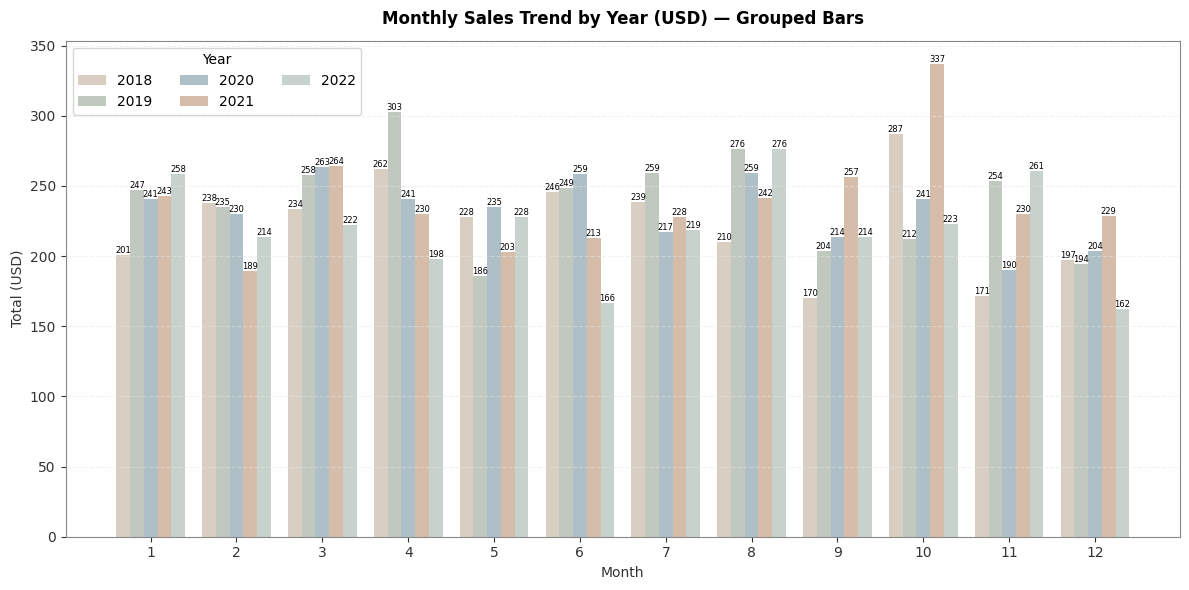

In [391]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

sql = """
select 
  extract(year from i.invoice_date)::int  as year_,
  extract(month from i.invoice_date)::int as month_,
  sum(il.unitprice * il.quantity) as total_usd
from dwh2.fact_invoiceline il
join dwh2.fact_invoice i on i.invoice_key = il.invoice_key
group by 1,2
order by 1,2
;
"""
df = pd.read_sql(sql, engine)

pvt = df.pivot(index="month_", columns="year_", values="total_usd").fillna(0).sort_index()
months = pvt.index.tolist()
years  = pvt.columns.tolist()
n_years = len(years)


PALETTE = ["#d8cfc2", "#c0c8bf", "#aebfc7", "#d6bda9", "#c7d2cc", "#bfc7d9"]  
colors = [PALETTE[i % len(PALETTE)] for i in range(n_years)]

plt.rcParams.update({
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.edgecolor": "#888888",
    "grid.color": "#e6e6e6",
})

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(months))
bar_width = 0.8 / max(n_years, 1) 

bars_per_year = []
for idx, yr in enumerate(years):
    offsets = [i - 0.4 + bar_width/2 + idx*bar_width for i in x]
    bars = ax.bar(offsets, pvt[yr].values, width=bar_width, label=str(yr), color=colors[idx])
    bars_per_year.append(bars)


ax.set_title("Monthly Sales Trend by Year (USD) — Grouped Bars", pad=12, fontsize=12)
ax.set_xlabel("Month")
ax.set_ylabel("Total (USD)")
ax.set_xticks(list(x))
ax.set_xticklabels(months)
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend(title="Year", ncol=min(3, n_years), frameon=True)


for bars in bars_per_year:
    for b in bars:
        v = b.get_height()
        if v > 0:
            ax.text(b.get_x() + b.get_width()/2, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=6)

plt.tight_layout()
plt.savefig("monthly_sales_trend_bars_using_SQL.png", dpi=180)
plt.show()


In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

sql_top_genres = """
with cust_track as (
 select fi.customer_key,
 		il.track_key 
 from dwh2.fact_invoiceline il
  join dwh2.fact_invoice fi on il.invoice_key = fi.invoice_key
),
cust_genre as (
 select c.customer_key,
		dt.genre,
		count(*) as cnt
 from cust_track c
 join dwh2.dim_track dt on c.track_key = dt.track_key 
 where dt.genre IS NOT NULL
 group by c.customer_key,
 		  dt.genre
),
ranked as (
 select 
	customer_key, 
	genre, 
	cnt,
    dense_rank() over(partition by customer_key order by cnt DESC, genre) as rnk
 from cust_genre
)
 select
	customer_key as customer_id,
	genre as genre_name
 from ranked
 where rnk <= 2
 order by customer_key,
 		  rnk, 
		  genre
;
"""
# שלב 2: כל השירים שהלקוח כבר רכש
sql_purchased = """
select
	fi.customer_key as customer_id, 
	il.track_key as track_id
from dwh2.fact_invoiceline il
join dwh2.fact_invoice fi on il.invoice_key = fi.invoice_key
;
"""
# שלב 3: פופולריות כללית של שירים לפי ז'אנר 
sql_popularity = """
with pop as (
 select dt.track_key,
 		dt.genre, 
		count(*) as purchases
 from dwh2.fact_invoiceline il
 join dwh2.dim_track dt on il.track_key = dt.track_key
 where dt.genre IS NOT NULL
 group by dt.track_key, 
 		  dt.genre
)
 select 
	tracK_key as track_id,
	genre as genre_name, 
	purchases
 from pop
;
"""

top_genres = pd.read_sql(sql_top_genres, engine)
purchased = pd.read_sql(sql_purchased, engine)
pop = pd.read_sql(sql_popularity, engine)

purchased_set = (
    purchased.groupby("customer_id")["track_id"]
    .apply(set)
    .to_dict()
)

pop_by_genre = (
    pop.sort_values(["genre_name", "purchases"], ascending=[True, False])
        .groupby("genre_name")["track_id"]
        .apply(list)
        .to_dict()
)

recs = []
for cust, sub in top_genres.groupby("customer_id"):
    owned = purchased_set.get(cust, set())
    for genre in sub["genre_name"].tolist():
        candidates = [t for t in pop_by_genre.get(genre, []) if t not in owned]
        chosen = candidates[:3] 
        recs.append({"customer_id ": cust, " genre_name ": genre, " recommended_track_ids": chosen})

df_recs = pd.DataFrame(recs)

# df_recs.to_csv("recommendations_using_SQL.csv", index=False)
print("PREVIEW:")
print("\n", df_recs.head(10))
# print("\nSAVED: recommendations_using_SQL.csv")

PREVIEW:

    customer_id   genre_name   recommended_track_ids
0             1         Rock     [2672, 2153, 1401]
1             1        Latin       [380, 1523, 241]
2             2         Rock     [2672, 2153, 1401]
3             2        Blues       [2541, 915, 892]
4             3        Metal      [1226, 416, 1834]
5             3         Jazz       [635, 1192, 467]
6             4         Rock     [2672, 2153, 1401]
7             4    Classical     [3446, 3500, 3482]
8             5         Rock     [2672, 2153, 2968]
9             5        Metal      [1226, 416, 1834]


In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)


il = pd.read_sql_query("select invoice_key, track_key from dwh2.fact_invoiceline", engine)
fi = pd.read_sql_query("select invoice_key, customer_key from dwh2.fact_invoice", engine)
dt = pd.read_sql_query("select track_key, genre from dwh2.dim_track", engine)

cust_track = fi.merge(il, on= "invoice_key", how= "inner")[["customer_key", "track_key"]]
cust_genre = cust_track.merge(dt, on= "track_key", how="inner")
cust_genre = cust_genre[cust_genre["genre"].notna()]
cust_genre_counts = (cust_genre.groupby(["customer_key", "genre"], as_index=False).size().rename(columns={"size": "cnt"}))
cust_genre_counts = cust_genre_counts.sort_values(["customer_key", "cnt", "genre"], ascending=[True, False, True]
                                                 ).reset_index(drop=True)

cust_genre_counts["pair"] = list(zip(cust_genre_counts["cnt"], cust_genre_counts["genre"]))
cust_genre_counts["rnk"] = (cust_genre_counts.groupby("customer_key")["pair"]
                     .transform(lambda s: pd.factorize(s)[0] + 1))

top_genres = (cust_genre_counts.loc[cust_genre_counts["rnk"] <= 2, ["customer_key", "genre", "rnk"]]
                   .rename(columns={"customer_key": "customer_id", "genre": "genre_name"})
                   .sort_values(["customer_id", "rnk", "genre_name"], ascending=[True, True, True])
                   .reset_index(drop=True))

purchased = (
    fi.merge(il, on= "invoice_key", how= "inner")[["customer_key", "track_key"]]
      .rename(columns= {"customer_key": "customer_id", "track_key": "track_id"}))

il_dt = il.merge(dt, on= "track_key", how= "inner")
il_dt = il_dt[il_dt["genre"].notna()]
pop = (il_dt.groupby(["track_key", "genre"], as_index=False)
         .size()
         .rename(columns={"size": "purchases", "track_key": "track_id", "genre": "genre_name"}))

purchased_set = (purchased.groupby("customer_id")["track_id"]
             .apply(set)
             .to_dict())
pop_by_genre = (pop.sort_values(["genre_name", "purchases"], ascending=[True, False])
       .groupby("genre_name")["track_id"]
       .apply(list)
       .to_dict())
recs = []
for cust, sub in top_genres.groupby("customer_id"):
    owned = purchased_set.get(cust, set())
    for genre in sub["genre_name"].tolist():
        candidates = [t for t in pop_by_genre.get(genre, []) if t not in owned]
        chosen = candidates[:3]
        recs.append({"customer_id ": cust, " genre_name ": genre, " recommended_track_ids": chosen})
df_recs = pd.DataFrame(recs)

df_recs.to_csv("recommendations_(using_pandas).csv", index=False)
print("PREVIEW:")
print("\n", df_recs.head(10))
print("\nSAVED: recommendations_(using_pandas).csv")


PREVIEW:

    customer_id   genre_name   recommended_track_ids
0             1         Rock     [2672, 1401, 2153]
1             1        Latin        [380, 241, 594]
2             2         Rock     [2672, 1401, 2153]
3             2        Blues        [195, 892, 900]
4             3        Metal      [1226, 416, 1353]
5             3         Jazz        [635, 124, 467]
6             4         Rock     [2672, 1401, 2153]
7             4    Classical     [3446, 3482, 3488]
8             5         Rock     [2672, 2153, 2968]
9             5        Metal      [1226, 416, 1353]

SAVED: recommendations_(using_pandas).csv


In [413]:
engine = create_engine(DB_URL)

sql_top_genres = """
with cust_track as (
 select fi.customer_key,
 		il.track_key 
 from dwh2.fact_invoiceline il
  join dwh2.fact_invoice fi on il.invoice_key = fi.invoice_key
),
cust_genre as (
 select c.customer_key,
		dt.genre,
		count(*) as cnt
 from cust_track c
 join dwh2.dim_track dt on c.track_key = dt.track_key 
 where dt.genre IS NOT NULL
 group by c.customer_key,
 		  dt.genre
),
ranked as (
 select 
	customer_key, 
	genre, 
	cnt,
    dense_rank() over(partition by customer_key order by cnt DESC, genre) as rnk
 from cust_genre
)
 select
	customer_key as customer_id,
	genre as genre_name
 from ranked
 where rnk <= 2
 order by customer_key,
 		  rnk, 
		  genre
;
"""
# שלב 2: כל השירים שהלקוח כבר רכש
sql_purchased = """
select
	fi.customer_key as customer_id, 
	il.track_key as track_id
from dwh2.fact_invoiceline il
join dwh2.fact_invoice fi on il.invoice_key = fi.invoice_key
;
"""
# שלב 3: פופולריות כללית של שירים לפי ז'אנר 
sql_popularity = """
with pop as (
 select dt.track_key,
 		dt.genre, 
		count(*) as purchases
 from dwh2.fact_invoiceline il
 join dwh2.dim_track dt on il.track_key = dt.track_key
 where dt.genre IS NOT NULL
 group by dt.track_key, 
 		  dt.genre
)
 select 
	tracK_key as track_id,
	genre as genre_name, 
	purchases
 from pop
;
"""

top_genres = pd.read_sql(sql_top_genres, engine)
purchased = pd.read_sql(sql_purchased, engine)
pop = pd.read_sql(sql_popularity, engine)

purchased_set = (
    purchased.groupby("customer_id")["track_id"]
    .apply(set)
    .to_dict()
)

pop_by_genre = (
    pop.sort_values(["genre_name", "purchases"], ascending=[True, False])
        .groupby("genre_name")["track_id"]
        .apply(list)
        .to_dict()
)

recs = []
for cust, sub in top_genres.groupby("customer_id"):
    owned = purchased_set.get(cust, set())
    for genre in sub["genre_name"].tolist():
        candidates = [t for t in pop_by_genre.get(genre, []) if t not in owned]
        chosen = candidates[:3] 
        recs.append({"customer_id ": cust, " genre_name ": genre, " recommended_track_ids": chosen})

df_recs = pd.DataFrame(recs)

df_recs.to_csv("recommendations_(using_SQL).csv", index=False)
print("PREVIEW:")
print("\n", df_recs.head(10))
print("\nSAVED: recommendations_(using_SQL).csv")

PREVIEW:

    customer_id   genre_name   recommended_track_ids
0             1         Rock     [2672, 2153, 1401]
1             1        Latin       [380, 1523, 241]
2             2         Rock     [2672, 2153, 1401]
3             2        Blues       [2541, 915, 892]
4             3        Metal      [1226, 416, 1834]
5             3         Jazz       [635, 1192, 467]
6             4         Rock     [2672, 2153, 1401]
7             4    Classical     [3446, 3500, 3482]
8             5         Rock     [2672, 2153, 2968]
9             5        Metal      [1226, 416, 1834]

SAVED: recommendations_(using_SQL).csv


In [425]:
import requests
import psycopg2
from psycopg2.extras import execute_values
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise ValueError("STOP! DB_URL not found!")
engine = create_engine(DB_URL)

API_BASE = "https://api.frankfurter.app" 
BASE = "USD"
TO   = "ILS"
TIMEOUT = 30

def get_invoice_date_range(conn):
    with conn.cursor() as cur:
        try:
            cur.execute("""
                select min(invoicedate)::date, max(invoicedate)::date
                from stg.invoice
            """)
            row = cur.fetchone()
            if row and row[0] and row[1]:
                return row[0].isoformat(), row[1].isoformat()
        except psycopg2.errors.UndefinedTable:
            conn.rollback()

        cur.execute("""
            select min(invoicedate)::date, max(invoicedate)::date
            from public.invoice
        """)
        row = cur.fetchone()
        if not row or not row[0] or not row[1]:
            raise RuntimeError("Could not determine invoice date range from STG or PUBLIC.")
        return row[0].isoformat(), row[1].isoformat()

def fetch_series(start, end):
    url = f"{API_BASE}/{start}..{end}?from={BASE}&to={TO}"
    resp = requests.get(url, timeout=TIMEOUT)
    resp.raise_for_status()
    data = resp.json()
    if "rates" not in data or not isinstance(data["rates"], dict):
        raise ValueError(f"Unexpected API response: {data}")
    rows = []
    for d, obj in sorted(data["rates"].items()):
        rate = obj.get(TO)
        if rate is None:
            continue
        rows.append((d, rate, "frankfurter.app"))
    return rows

def ensure_table(conn):
    with conn.cursor() as cur:
        cur.execute("""
        create schema if not exists stg;
        create table if not exists stg.usd_ils_rates(
            rate_date   date primary key,
            usd_ils_rate numeric(18,8) not null,
            source      text not null default 'frankfurter.app',
            loaded_at   timestamptz not null default now()
        );
        """)
    conn.commit()

def upsert_rates(conn, rows):
    if not rows:
        return 0
    with conn.cursor() as cur:
        execute_values(cur, """
            insert into stg.usd_ils_rates(rate_date, usd_ils_rate, source)
            values %s
            on conflict (rate_date) do update
              set usd_ils_rate = excluded.usd_ils_rate,
                  source      = excluded.source,
                  loaded_at   = now()
        """, rows)
    conn.commit()
    return len(rows)

def main():
    conn = psycopg2.connect(DB_URL)
    try:
        ensure_table(conn)
        start, end = get_invoice_date_range(conn)
        print(f"Invoice date range (source): {start}..{end}")
        rows = fetch_series(start, end)
        n = upsert_rates(conn, rows)
        print(f"Done. Rows upserted into stg.usd_ils_rates: {n}")
    finally:
        conn.close()

if __name__ == "__main__":
    main()

Invoice date range (source): 2018-01-01..2022-12-22
Done. Rows upserted into stg.usd_ils_rates: 261


In [423]:
# import os

# root_path = r"C:\Users\IMOE001\Desktop\chinook-final-project"

# for root, dirs, files in os.walk(root_path, topdown=True):
#     level = root.replace(root_path, "").count(os.sep)
#     indent = " " * 4 * (level)
#     print(f"{indent}{os.path.basename(root)}/")
#     subindent = " " * 4 * (level + 1)
#     for f in files:
#         print(f"{subindent}{f}")


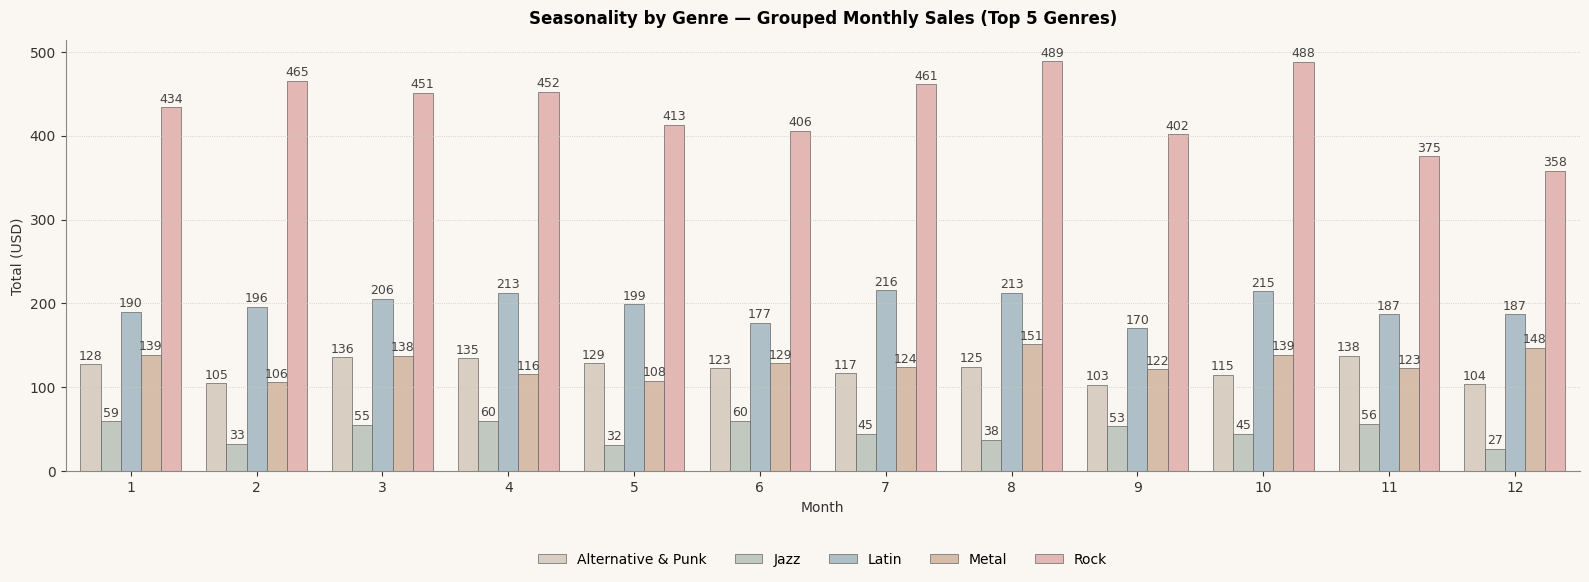

In [459]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise RuntimeError("DB_URL is not set in .env")

engine = create_engine(DB_URL)

SQL = """select
    i.invoice_date::date as invoice_date,
    t.genre,
    il.line_total as amount_usd
from dwh2.fact_invoiceline il
join dwh2.fact_invoice i on i.invoice_key = il.invoice_key
join dwh2.dim_track t on t.track_key = il.track_key;
"""
df = pd.read_sql(SQL, engine)
if df.empty:
    raise RuntimeError("DWH2 returned no rows. Check your ETL / tables.")

df["invoice_date"] = pd.to_datetime(df["invoice_date"])
df["month"] = df["invoice_date"].dt.month

agg = (df.groupby(["month", "genre"], as_index=False)["amount_usd"].sum().rename(columns={"amount_usd": "total_usd"}))
top5 = (agg.groupby("genre")["total_usd"]
       .sum()
       .sort_values(ascending=False)
       .head(5)
       .index
       .tolist())
preferred = ["Alternative & Punk", "Jazz", "Latin", "Metal", "Rock"]
order = [g for g in preferred if g in top5] + [g for g in top5 if g not in preferred]
agg_top = agg[agg["genre"].isin(order)].copy()

pivot = (agg_top.pivot_table(
        index= "month", columns="genre", values="total_usd", aggfunc="sum")
         .reindex(range(1, 13))
           .fillna(0.0))

pivot = pivot[[c for c in order if c in pivot.columns]]

pastel_colors = [
    "#d8cfc2",
    "#c0c8bf",
    "#aebfc7",
    "#d6bda9",
    "#e3b7b3",
    "#b5cbb7",
]

fig, ax = plt.subplots(figsize=(16, 6))

months = pivot.index.to_list()
genres = list(pivot.columns)
n_groups = len(months)
n_bars   = max(len(genres), 1)
bar_width = 0.8 / n_bars
x_base = pd.Series(range(n_groups), index=months)

for i, g in enumerate(genres):
    x = x_base + (i - (n_bars - 1) / 2) * bar_width
    bars = ax.bar(
        x,
        pivot[g].values,
        width=bar_width,
        label=g,
        color=pastel_colors[i % len(pastel_colors)],  
        edgecolor="#666", linewidth=0.5)
    
    for b, val in zip(bars, pivot[g].values):
        ax.text(
            b.get_x() + b.get_width()/2, b.get_height()+2,
            f"{int(round(val))}",
            ha="center", va="bottom", fontsize=9, color="#444")
        
ax.set_title("Seasonality by Genre — Grouped Monthly Sales (Top 5 Genres)")
ax.set_xlabel("Month")
ax.set_ylabel("Total (USD)")
ax.set_xticks(range(n_groups))
ax.set_xticklabels(months)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25),
          ncol= min(len(genres), 5),
          frameon=False,
          fontsize= 10)
ax.margins(x=0.01)
ax.set_facecolor("#faf7f2") 
fig.patch.set_facecolor("#faf7f2")
ax.grid(axis="y", linestyle=":", linewidth=0.6, color="#cfc8bc")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()


fig.savefig("seasonality_by_genre.png", dpi=160)
plt.show()


In [460]:
# # 03_currency_api_loader.py — Optional loader for USD→ILS daily rates
# # בטוח כברירת מחדל: DRY_RUN=True לא נוגע ב-DB, רק בודק הכל.

# import os
# from datetime import date
# from typing import Optional, Tuple

# import requests
# import pandas as pd
# from sqlalchemy import create_engine, text
# from dotenv import load_dotenv

# # ========= קונפיג =========
# DRY_RUN: bool = True                      # True = לא כותב ל-DB, רק בדיקות/הדפסות
# TARGET_SCHEMA = "stg"
# TARGET_TABLE  = "usd_ils_rates"

# # סדר עדיפויות למקורות טווח תאריכים (נבדק לפי הסדר):
# CANDIDATE_SOURCES = [
#     # (schema, table, date_column, sql_cast)
#     ("dwh2", "fact_invoice", "invoice_date", "invoice_date"),
#     (None,  "Invoice",      "InvoiceDate",  '"InvoiceDate"'),
# ]

# # טווח ידני לגיבוי (אם לא נמצאה אף טבלה למעלה) — להתאים אם צריך
# FALLBACK_DATES: Optional[Tuple[str, str]] = None  # למשל: ("2009-01-01","2013-12-31")

# # ========= עזר =========
# def find_date_range(engine) -> Tuple[str, str, str]:
#     """
#     מאתר טווח תאריכים למטבע לפי המקורות המוגדרים.
#     מחזיר (start_date, end_date, origin_text) בפורמט YYYY-MM-DD.
#     """
#     with engine.connect() as conn:
#         for sch, tbl, col, cast_col in CANDIDATE_SOURCES:
#             if sch:
#                 exists_sql = """
#                     SELECT 1
#                     FROM information_schema.tables
#                     WHERE table_schema=:sch AND table_name=:tbl
#                     LIMIT 1
#                 """
#                 exists = conn.execute(text(exists_sql), {"sch": sch, "tbl": tbl}).scalar()
#                 fq_name = f"{sch}.{tbl}"
#             else:
#                 # טבלת public עם ציטוטי אותיות גדולות (Chinook)
#                 exists_sql = """
#                     SELECT 1
#                     FROM information_schema.tables
#                     WHERE table_schema='public' AND table_name=:tbl
#                     LIMIT 1
#                 """
#                 exists = conn.execute(text(exists_sql), {"tbl": tbl}).scalar()
#                 fq_name = f'public."{tbl}"'

#             if exists:
#                 rng_sql = f"""
#                     SELECT
#                         MIN({cast_col})::date AS start_date,
#                         MAX({cast_col})::date AS end_date
#                     FROM {fq_name}
#                 """
#                 row = conn.execute(text(rng_sql)).one_or_none()
#                 if row and row[0] and row[1]:
#                     s, e = str(row[0]), str(row[1])
#                     return s, e, fq_name

#         # לא נמצא מקור? נשתמש בטווח ידני אם הוגדר
#         if FALLBACK_DATES:
#             s, e = FALLBACK_DATES
#             return s, e, "manual_range"

#     raise SystemExit("לא נמצא מקור לטווח תאריכים (fact_invoice / Invoice), ולא הוגדר FALLBACK_DATES.")

# def fetch_rates(start_date: str, end_date: str) -> pd.DataFrame:
#     """
#     מושך שערים יומיים USD→ILS בעזרת exchangerate.host (ללא מפתח).
#     מחזיר DataFrame עם עמודות: rate_date, usd_ils_rate.
#     """
#     url = (
#         "https://api.exchangerate.host/timeseries"
#         f"?start_date={start_date}"
#         f"&end_date={end_date}"
#         f"&base=USD&symbols=ILS"
#     )
#     resp = requests.get(url, timeout=20)
#     resp.raise_for_status()
#     data = resp.json()

#     if not data.get("success") or "rates" not in data:
#         raise RuntimeError("API השיב ללא success או ללא rates.")

#     rows = []
#     for d, obj in sorted(data["rates"].items()):
#         ils = obj.get("ILS")
#         if ils is None:
#             continue  # יום חסר — נדלג (אפשר גם להשלים בהמשך לפי צורך)
#         rows.append({"rate_date": d, "usd_ils_rate": float(ils)})

#     if not rows:
#         raise RuntimeError("לא חזרו שערים כלל מן ה-API לטווח שנבחר.")

#     return pd.DataFrame(rows).sort_values("rate_date").reset_index(drop=True)

# def load_to_db(engine, df: pd.DataFrame):
#     """
#     טוען את הטבלה ל-stg.usd_ils_rates (מחליף אם קיים).
#     """
#     with engine.begin() as conn:
#         user = conn.execute(text("select current_user")).scalar()
#         conn.execute(text(f"create schema if not exists {TARGET_SCHEMA} authorization {user}"))
#         df.to_sql(
#             TARGET_TABLE,
#             con=conn,
#             schema=TARGET_SCHEMA,
#             if_exists="replace",
#             index=False
#         )

# def main():
#     load_dotenv()
#     db_url = os.getenv("DB_URL")
#     if not db_url:
#         raise SystemExit("חסר DB_URL ב-.env")
#     engine = create_engine(db_url)

#     # 1) איתור טווח תאריכים
#     s, e, origin = find_date_range(engine)
#     print(f"[range] {s} → {e}  (origin: {origin})")

#     # 2) משיכת שערים
#     df = fetch_rates(s, e)
#     print(f"[api] fetched {len(df)} daily rates, sample:")
#     print(df.head())

#     # 3) טעינה ל-DB (אלא אם DRY_RUN)
#     if DRY_RUN:
#         print(f"[dry-run] לא נטען ל-DB. כאשר תהיי מרוצה מהפלט, שנה/י DRY_RUN=False")
#         print(f"[target] {TARGET_SCHEMA}.{TARGET_TABLE}")
#         return

#     load_to_db(engine, df)
#     print(f"[done] loaded {len(df)} rows into {TARGET_SCHEMA}.{TARGET_TABLE}")

# if __name__ == "__main__":
#     main()


[range] 2018-01-01 → 2022-12-22  (origin: dwh2.fact_invoice)


RuntimeError: API השיב ללא success או ללא rates.

In [461]:
import requests
url = "https://api.exchangerate.host/latest?base=USD&symbols=ILS"
r = requests.get(url, timeout=20)
print("status:", r.status_code)
print("json keys:", list(r.json().keys()) if r.headers.get("content-type","").startswith("application/json") else r.text[:400])


status: 200
json keys: ['success', 'error']


In [462]:
import os
from datetime import datetime, date
import time
import pandas as pd
import requests
from sqlalchemy import create_engine, text
from sqlalchemy.types import Date as SA_Date, Numeric as SA_Numeric
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")
if not DB_URL:
    raise RuntimeError("DB_URL is missing")

ENGINE = create_engine(DB_URL)

TARGET_SCHEMA = "stg"
TARGET_TABLE = "usd_ils_rates"
DRY_RUN = True  # set to False to load into db

def find_date_range(engine):
    q = """
    select min(i.invoice_date)::date as s, max(i.invoice_date)::date as e
    from dwh2.fact_invoice i
    """
    s, e = pd.read_sql(q, engine).iloc[0]
    if s is None or e is None:
        raise RuntimeError("no dates in dwh2.fact_invoice")
    return str(s), str(e)

def fetch_rates(start_date: str, end_date: str) -> pd.DataFrame:
    try:
        url = (
            "https://api.exchangerate.host/timeseries"
            f"?start_date={start_date}&end_date={end_date}"
            f"&base=USD&symbols=ILS"
        )
        r = requests.get(url, timeout=25)
        r.raise_for_status()
        data = r.json()
        if isinstance(data, dict) and data.get("success") and "rates" in data:
            rows = []
            for d, obj in sorted(data["rates"].items()):
                ils = obj.get("ILS")
                if ils is None:
                    continue
                rows.append({"rate_date": d, "usd_ils_rate": float(ils)})
            if rows:
                return (
                    pd.DataFrame(rows)
                    .sort_values("rate_date")
                    .reset_index(drop=True)
                )
    except Exception:
        pass

    def year_chunks(s: date, e: date):
        y = s.year
        while y <= e.year:
            cs = date(y, 1, 1) if y > s.year else s
            ce = date(y, 12, 31) if y < e.year else e
            yield cs, ce
            y += 1

    s = datetime.strptime(start_date, "%Y-%m-%d").date()
    e = datetime.strptime(end_date, "%Y-%m-%d").date()

    rows = []
    for cs, ce in year_chunks(s, e):
        url = f"https://api.frankfurter.app/{cs}..{ce}?from=USD&to=ILS"
        rr = requests.get(url, timeout=25)
        rr.raise_for_status()
        dj = rr.json()
        if "rates" not in dj:
            raise RuntimeError(f"frankfurter payload error for {cs}..{ce}")
        for d, obj in sorted(dj["rates"].items()):
            ils = obj.get("ILS")
            if ils is None:
                continue
            rows.append({"rate_date": d, "usd_ils_rate": float(ils)})
        time.sleep(0.3)

    if not rows:
        raise RuntimeError("no rates fetched")
    return pd.DataFrame(rows).sort_values("rate_date").reset_index(drop=True)

def ensure_schema_and_table(engine):
    with engine.begin() as conn:
        conn.execute(text(f"create schema if not exists {TARGET_SCHEMA} authorization current_user"))
        conn.execute(text(f"""
            create table if not exists {TARGET_SCHEMA}.{TARGET_TABLE}(
                rate_date date primary key,
                usd_ils_rate numeric
            )
        """))

def load_to_db(engine, df, start_date, end_date):
    ensure_schema_and_table(engine)
    with engine.begin() as conn:
        conn.execute(
            text(f"delete from {TARGET_SCHEMA}.{TARGET_TABLE} where rate_date between :s and :e"),
            {"s": start_date, "e": end_date},
        )
    df.to_sql(
        TARGET_TABLE,
        engine,
        schema=TARGET_SCHEMA,
        if_exists="append",
        index=False,
        dtype={"rate_date": SA_Date(), "usd_ils_rate": SA_Numeric()},
        method="multi",
        chunksize=1000,
    )

def main():
    s, e = find_date_range(ENGINE)
    print(f"[range] {s} -> {e}")
    df = fetch_rates(s, e)
    print(f"[api] fetched {len(df)} rows, sample:")
    print(df.head())
    if DRY_RUN:
        print("[dry-run] no db writes")
        return
    load_to_db(ENGINE, df, s, e)
    with ENGINE.connect() as conn:
        cnt, mn, mx = conn.execute(
            text(f"select count(*), min(rate_date), max(rate_date) from {TARGET_SCHEMA}.{TARGET_TABLE}")
        ).fetchone()
    print(f"[done] table {TARGET_SCHEMA}.{TARGET_TABLE}: rows={cnt}, range {mn}..{mx}")

if __name__ == "__main__":
    main()


[range] 2018-01-01 -> 2022-12-22
[api] fetched 1282 rows, sample:
    rate_date  usd_ils_rate
0  2017-12-29        3.4716
1  2018-01-02        3.4557
2  2018-01-03        3.4590
3  2018-01-04        3.4462
4  2018-01-05        3.4373
[dry-run] no db writes


In [469]:
import os
from datetime import datetime, date
import requests
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

load_dotenv()
DB_URL = os.getenv("DB_URL")

TARGET_SCHEMA = "stg"
TARGET_TABLE = "usd_ils_rates"
DRY_RUN = True

def find_date_range(engine):
    with engine.connect() as conn:
        s, e = conn.execute(text("""
            select min(invoice_date)::date, max(invoice_date)::date
            from dwh2.fact_invoice
        """)).fetchone()
    return s, e

def fetch_rates(s, e):
    url = f"https://api.frankfurter.app/{s}..{e}?from=USD&to=ILS"
    r = requests.get(url, timeout=20)
    if r.status_code != 200:
        raise RuntimeError("api status not 200")
    data = r.json()
    if "rates" not in data:
        raise RuntimeError("api has no rates key")
    rows = []
    for d, obj in sorted(data["rates"].items()):
        rows.append({"rate_date": pd.to_datetime(d).date(), "usd_ils_rate": float(obj["ILS"])})
    return pd.DataFrame(rows)

def load_to_db(engine, df):
    with engine.begin() as conn:
        conn.execute(text(f"create schema if not exists {TARGET_SCHEMA} authorization current_user"))
        conn.execute(text(f"""
            create table if not exists {TARGET_SCHEMA}.{TARGET_TABLE}(
                rate_date date primary key,
                usd_ils_rate numeric,
                source text default 'frankfurter.app',
                loaded_at timestamptz default now()
            )
        """))
        now = datetime.utcnow()
        rows = [
            {
                "rate_date": r.rate_date,
                "usd_ils_rate": float(r.usd_ils_rate),
                "source": "frankfurter.app",
                "loaded_at": now,
            }
            for r in df.itertuples(index=False)
        ]
        conn.execute(
            text(f"""
                insert into {TARGET_SCHEMA}.{TARGET_TABLE}
                    (rate_date, usd_ils_rate, source, loaded_at)
                values
                    (:rate_date, :usd_ils_rate, :source, :loaded_at)
                on conflict (rate_date) do update
                set usd_ils_rate = excluded.usd_ils_rate,
                    source       = excluded.source,
                    loaded_at    = excluded.loaded_at
            """),
            rows
        )

def main():
    engine = create_engine(DB_URL)
    s, e = find_date_range(engine)
    print(f"[range] {s} -> {e}")
    df = fetch_rates(s, e)
    print(f"[api] fetched {len(df)} rows, sample:")
    print(df.head())
    if DRY_RUN:
        print("[dry-run] no db writes")
        return
    load_to_db(engine, df)
    with engine.connect() as conn:
        cnt, mn, mx = conn.execute(
            text(f"select count(*), min(rate_date), max(rate_date) from {TARGET_SCHEMA}.{TARGET_TABLE}")
        ).fetchone()
    print(f"[done] {TARGET_SCHEMA}.{TARGET_TABLE} rows={cnt}, range {mn}..{mx}")

if __name__ == "__main__":
    main()


[range] 2018-01-01 -> 2022-12-22
[api] fetched 261 rows, sample:
    rate_date  usd_ils_rate
0  2017-12-25        3.4716
1  2018-01-01        3.4494
2  2018-01-08        3.4278
3  2018-01-15        3.4225
4  2018-01-22        3.4081
[dry-run] no db writes
